# **Initial Analysis of Control Run**

Computation of metrics from the control simulation necessary for calculating the potential prognostic predictability (PPP). 

**Important metrics:**

- SH sea ice extent/volume
- regional sea ice extent/volume
- regional NPP, PCO2, SSS, SST
- gridpoint-level fields for sea ice concentration, SST, SSS, NPP, PCO2
- sea ice edge position (latitude at which sea ice concentration drops below 15%)

In [64]:
import os
import warnings
warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")
warnings.filterwarnings("ignore", message="Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range")
warnings.filterwarnings("ignore", message="invalid value encountered in reduce")

import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

### Functions

In [65]:
## return the size of the dataset in gigabytes GB (not gibibytes GiB)
def size(da):
    return str(da.nbytes / (1000**3))+' gigabytes'

In [66]:
## compute the climatology (time mean for each month)
def compute_clim(da):
    time = 'time'
    try:
        clim = da.groupby('time.month').mean(dim='time')
    except:
        time = time.upper()
        clim = da.groupby(time+'.month').mean(dim=time)
    
    clim = clim.rename(da.name+'_clim')
    return clim

In [67]:
## compute the monthly anomalies from the 300-year control runs
def compute_anom(da):
    time = 'time'
    try:
        clim = da.groupby('time.month').mean(dim='time')
    except:
        time = time.upper()
        clim = da.groupby(time+'.month').mean(dim=time)
        
    anom = da.groupby(time+'.month') - clim
    anom = anom.rename(da.name+'_anom')
    return anom

In [68]:
## compute the variance
def compute_variance(da): 
    time = 'time'
    try:
        clim = da.groupby('time.month').mean(dim='time')
    except:
        time = time.upper()
        clim = da.groupby(time+'.month').mean(dim=time)
        
    anom = da.groupby(time+'.month') - clim
    
    variance = anom.groupby(time+'.month').var(dim=time)
    variance = variance.rename(da.name+'_variance')
    return variance

In [69]:
## save climatology data
def save_ctrl_clim(var, da, write_rootdir, subdir, regional):
    if regional == False:
        filename = var.lower()+'_ctrl_global_climatology.nc'
    elif regional == True:
        filename = var.lower()+'_ctrl_so_climatology.nc'
    else:
        print('the parameter \'regional\' must be boolean')
        return
    da.to_netcdf(write_rootdir+subdir+var.upper()+'/'+filename)

In [70]:
## save anomaly data
def save_ctrl_anom(var, da, write_rootdir, subdir, regional):
    if regional == False:
        filename = var.lower()+'_ctrl_global_anomaly.nc'
    elif regional == True:
        filename = var.lower()+'_ctrl_so_anomaly.nc'
    else:
        print('the parameter \'regional\' must be a boolean')
        return
    da.to_netcdf(write_rootdir+subdir+var.upper()+'/'+filename)

In [71]:
## save variance data
def save_ctrl_variance(var, da, write_rootdir, subdir, regional):
    if regional == False:
        filename = var.lower()+'_ctrl_global_variance.nc'
    elif regional == True:
        filename = var.lower()+'_ctrl_so_variance.nc'
    else:
        print('the parameter \'regional\' must be a boolean')
        return
    da.to_netcdf(write_rootdir+subdir+var.upper()+'/'+filename)

**Resize DataArray to Southern Ocean region (latitude <= -40.5$^{\circ}$N)**

For this model data, ```yt_ocean``` is equal to ```geolat_t``` in the Southern Hemisphere. For simplicity, ```yt_ocean``` is used to resize the data.

The ```da``` DataArray parameter requires the following coordinates - case sensitive:
    ```{'time', 'yt_ocean', 'xt_ocean', 'geolat_t', 'geolon_t'}```

In [72]:
def SouthernOcean_resize(da, time):
    if time == True:
        so = da.drop({'time', 'xt_ocean', 'yt_ocean', 'geolon_t', 'geolat_t'})
        so = so[:,:42].assign_coords({'time':da.time})
        so = so.assign_coords({'yt_ocean':da.yt_ocean[:42], 'xt_ocean':da.xt_ocean})
        so = so.assign_coords({'geolon_t':da.geolon_t[:42,:], 'geolat_t':da.geolat_t[:42,:]})
        
    elif time == False:
        so = da.drop({'xt_ocean', 'yt_ocean', 'geolon_t', 'geolat_t'})
        so = so[:42,:]
        so = so.assign_coords({'yt_ocean':da.yt_ocean[:42], 'xt_ocean':da.xt_ocean})
        so = so.assign_coords({'geolon_t':da.geolon_t[:42,:], 'geolat_t':da.geolat_t[:42,:]})
    
    else:
        print('the parameter \'time\' must be a boolean')
        return
    
    return so

# Analysis

In [73]:
rootdir = '/local/projects/so_predict/esm2m_froelicher/'
write_rootdir = '/home/bbuchovecky/storage/so_predict_derived/'

subdir_ctrl = 'CTRL/'
subdir_grid = 'GRID/'

**First, grab ```geolon_t``` and ```geolat_t``` from ocean model grid data. These coordinates will be added to all variables for reference.**

In [74]:
ocean_grid = xr.open_dataset(rootdir+subdir_grid+'ocean.static.nc')

geolat_t = ocean_grid.geolat_t
geolon_t = ocean_grid.geolon_t

**Create regional masks to use with datasets.**

In [75]:
## Southern Ocean mask
SouthernOcean_mask = xr.where(ocean_grid.geolat_t < -40, 1, 0)
SouthernOcean_mask.name = 'SouthernOcean'
Weddell_mask.attrs = {'lon_bnds':'[180 degW, 180 degE]', 'lat_bnds':'[81.5 degS, 40.5 degS]',
                     'geolon_t_bnds':'[-59.5, 19.5]', 'geolat_t_bnds':'[-81.5, -40.5]'}

## Weddell Sea region mask
Weddell_mask = xr.where(ocean_grid.geolon_t > -60, 1, 0)
Weddell_mask = xr.where(ocean_grid.geolon_t < 20, Weddell_mask, 0)
Weddell_mask = xr.where(SouthernOcean_mask > 0, Weddell_mask, 0)
Weddell_mask.name = 'Weddell'
Weddell_mask.attrs = {'lon_bnds':'[60 degW, 20 degE]', 'lat_bnds':'[81.5 degS, 90 degN]',
                     'geolon_t_bnds':'[-59.5, 19.5]', 'geolat_t_bnds':'[-81.5, 89.48786]'}

## Indian Ocean region mask
Indian_mask = xr.where(ocean_grid.geolon_t > 20, 1, 0)
Indian_mask = xr.where(ocean_grid.geolon_t < -270, 1, Indian_mask)
Indian_mask = xr.where(SouthernOcean_mask > 0, Indian_mask, 0)
Indian_mask.name = 'Indian'
Indian_mask.attrs = {'lon_bnds':'[20 degE, 90 degE]', 'lat_bnds':'[81.5 degS, 90 degN]',
                     'geolon_t_bnds':'[-279.5, -270.5], [20.5, 79.5]',
                     'geolat_t_bnds':'[-81.5, 89.48786]'}

## West Pacific Ocean region mask
WestPacific_mask = xr.where(ocean_grid.geolon_t > -270, 1, 0)
WestPacific_mask = xr.where(ocean_grid.geolon_t < -200, WestPacific_mask, 0)
WestPacific_mask = xr.where(SouthernOcean_mask > 0, WestPacific_mask, 0)
WestPacific_mask.name = 'WestPacific'
WestPacific_mask.attrs = {'lon_bnds':'[90 degE, 160 degE]', 'lat_bnds':'[81.5 degS, 90 degN]',
                          'geolon_t_bnds':'[-269.5, -200.5]', 'geolat_t_bnds':'[-81.5, 89.48786]'}

## Ross Sea region mask
Ross_mask = xr.where(ocean_grid.geolon_t > -200, 1, 0)
Ross_mask = xr.where(ocean_grid.geolon_t < -130, Ross_mask, 0)
Ross_mask = xr.where(SouthernOcean_mask > 0, Ross_mask, 0)
Ross_mask.name = 'Ross'
Ross_mask.attrs = {'lon_bnds':'[160 degE, 130 degW]', 'lat_bnds':'[81.5 degS, 90 degN]',
                   'geolon_t_bnds':'[-199.5, -130.5]', 'geolat_t_bnds':'[-81.5, 89.48786]'}

## Amundsen Sea and Bellingshausen Sea region mask
AmundBell_mask = xr.where(ocean_grid.geolon_t > -130, 1, 0)
AmundBell_mask = xr.where(ocean_grid.geolon_t < -60, AmundBell_mask, 0)
AmundBell_mask = xr.where(SouthernOcean_mask > 0, AmundBell_mask, 0)
AmundBell_mask.name = 'AmundBell'
AmundBell_mask.attrs = {'long_name':'Amundsen and Bellingshausen Region', 
                        'lon_bnds':'[130 degW, 60 degW]', 'lat_bnds':'[81.5 degS, 90 degN, ]',
                        'geolon_t_bnds':'[-129.5, -60.5]', 'geolat_t_bnds':'[-81.5, 89.48786]'}

In [76]:
regional_masks = xr.merge([SouthernOcean_mask, Weddell_mask, Indian_mask, WestPacific_mask, Ross_mask, AmundBell_mask])
regional_masks.attrs = {'description':'global masks for Southern Ocean regions'}

In [77]:
# Weddell_mask.plot()
# Indian_mask.plot()
# WestPacific_mask.plot()
# Ross_mask.plot()
# AmundBell_mask.plot()

**I realized after the fact that I can apply ```.where()``` with a global mask to resized DataArrays, so the following code is not necessary at this point. However, it could be useful down the line and I'll keep it here.**

In [78]:
def set_SO_lon_attrs(da):
    da.attrs['lat_bnds'] = '[40 degS, 81.5 degS]'
    da.attrs['geolat_t_bnds'] = '[-81.5, -40.5]'

Weddell_SO_mask = SouthernOcean_resize(Weddell_mask, time=False)
set_SO_lon_attrs(Weddell_SO_mask)

Indian_SO_mask = SouthernOcean_resize(Indian_mask, time=False)
set_SO_lon_attrs(Indian_SO_mask)

WestPacific_SO_mask = SouthernOcean_resize(WestPacific_mask, time=False)
set_SO_lon_attrs(WestPacific_SO_mask)

Ross_SO_mask = SouthernOcean_resize(Ross_mask, time=False)
set_SO_lon_attrs(Ross_SO_mask)

AmundBell_SO_mask = SouthernOcean_resize(AmundBell_mask, time=False)
set_SO_lon_attrs(AmundBell_SO_mask)

In [79]:
regional_SO_masks = xr.merge([Weddell_SO_mask, Indian_SO_mask, WestPacific_SO_mask, Ross_SO_mask, AmundBell_SO_mask])
regional_SO_masks.attrs = {'description':'masks for Southern Ocean regions (latitude resized to south of 41.5 degS)'}

In [80]:
## already saved

regional_masks.to_netcdf(write_rootdir+'/regional_global_masks.nc', mode='w')
regional_SO_masks.to_netcdf(write_rootdir+'/regional_so_masks.nc', mode='w')

In [81]:
sorted(os.listdir(write_rootdir))

['CTRL', 'regional_global_masks.nc', 'regional_so_masks.nc']

## Gridpoint-level Fields

#### Sea Surface Temperature (SST)

In [82]:
path_sst = rootdir+subdir_ctrl+'/SST/sst_*.nc'
var_sst = 'sst'

ds_sst = xr.open_mfdataset(path_sst)

In [83]:
sst_attrs = ds_sst[var_sst].attrs
sst_metrics_attrs = {'long_name':'Potential Temperature', 'units':sst_attrs['units'],
                     'valid range':sst_attrs['valid_range'], 'coordinates':'geolon_t, geolat_t'}

**Global SST**

In [84]:
sst_clim = compute_clim(ds_sst[var_sst])
sst_clim.attrs = sst_metrics_attrs
sst_clim.attrs['description'] = 'sea surface temperature monthly climatology'

sst_anom = compute_anom(ds_sst[var_sst])
sst_anom.attrs = sst_metrics_attrs
sst_anom.attrs['description'] = 'sea surface temperature monthly anomaly'

sst_variance = compute_variance(ds_sst[var_sst])
sst_variance.attrs = {'long_name':'Potential Temperature Variance', 'units':sst_attrs['units']+' ^2',
                      'coordinates':'geolon_t, geolat_t', 'description':'variance of sea surface temperature monthly anomaly'}

**Southern Ocean SST (resized)**

In [85]:
sst_so = SouthernOcean_resize(ds_sst[var_sst], time=True)

sst_clim_so = compute_clim(sst_so)
sst_clim_so.attrs = sst_metrics_attrs
sst_clim_so.attrs['description'] = 'sea surface temperature monthly climatology'

sst_anom_so = compute_anom(sst_so)
sst_anom_so.attrs = sst_metrics_attrs
sst_anom_so.attrs['description'] = 'sea surface temperature monthly anomaly'

sst_variance_so = compute_variance(sst_so)
sst_variance_so.attrs = {'long_name':'Potential Temperature Variance', 'units':sst_attrs['units']+' ^2',
                         'coordinates':'geolon_t, geolat_t', 'description':'variance of sea surface temperature monthly anomaly'}

**Note:** Resizing from global to just the Southern Ocean significantly reduces file size (see below).

In [86]:
size(sst_anom)

'1.0368 gigabytes'

In [87]:
size(sst_anom_so)

'0.217728 gigabytes'

**Save files**

In [88]:
## already saved

# save_ctrl_clim(var_sst, sst_clim, write_rootdir, subdir_ctrl, regional=False)
# save_ctrl_clim(var_sst, sst_clim_so, write_rootdir, subdir_ctrl, regional=True)

# save_ctrl_anom(var_sst, sst_anom, write_rootdir, subdir_ctrl, regional=False)
# save_ctrl_anom(var_sst, sst_anom_so, write_rootdir, subdir_ctrl, regional=True)

# save_ctrl_variance(var_sst, sst_variance, write_rootdir, subdir_ctrl, regional=False)
# save_ctrl_variance(var_sst, sst_variance_so, write_rootdir, subdir_ctrl, regional=True)

In [89]:
## check that files were saved correctly
sorted(os.listdir(write_rootdir+subdir_ctrl+var_sst.upper()+'/'))

['SST_raw',
 'ocean.static.nc',
 'sst_ctrl_global_anomaly.nc',
 'sst_ctrl_global_climatology.nc',
 'sst_ctrl_global_variance.nc',
 'sst_ctrl_so_anomaly.nc',
 'sst_ctrl_so_climatology.nc',
 'sst_ctrl_so_variance.nc']

**Check computations with simple plots**

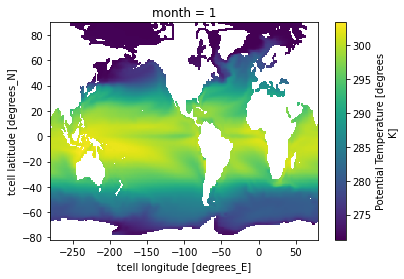

In [90]:
sst_clim[0].plot()

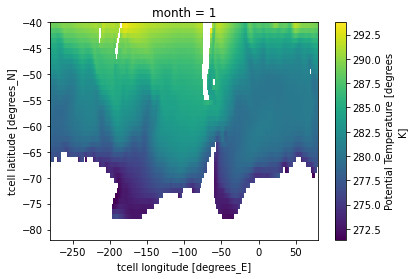

In [91]:
sst_clim_so[0].plot()

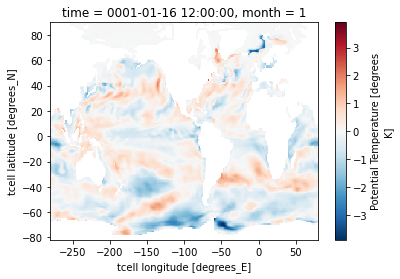

In [92]:
sst_anom[0].plot()

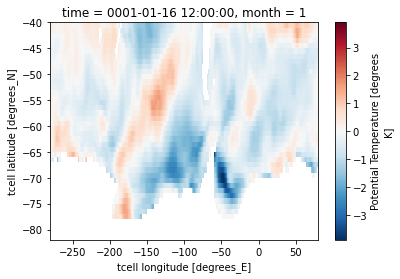

In [93]:
sst_anom_so[0].plot()

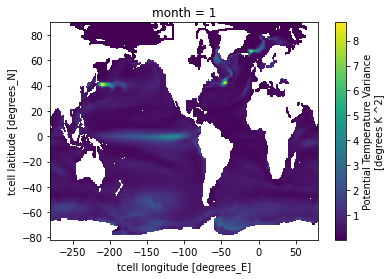

In [94]:
sst_variance[0].plot()

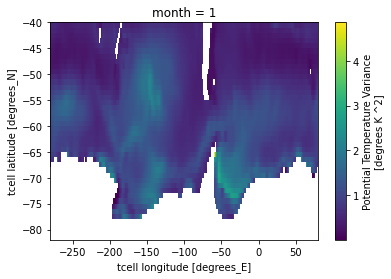

In [95]:
sst_variance_so[0].plot()

#### Sea Surface Salinity (SSS)

In [96]:
path_sss = rootdir+subdir_ctrl+'/SSS/sss_*.nc'
var_sss = 'sss'

ds_sss = xr.open_mfdataset(path_sss)

## add geolon_t and geolat_t coordinates
ds_sss = ds_sss.assign_coords({'geolon_t':geolon_t, 'geolat_t':geolat_t})

In [97]:
sss_attrs = ds_sss[var_sss].attrs
sss_metrics_attrs = {'long_name':'Practical Salinity', 'units':'psu', 'valid_range':sss_attrs['valid_range'],
                    'coordinates':'geolon_t, geolat_t'}

**Global SSS**

In [98]:
sss_clim = compute_clim(ds_sss[var_sss])
sss_clim.attrs = sss_metrics_attrs
sss_clim.attrs['description'] = 'sea surface salinity monthly climatology'

sss_anom = compute_anom(ds_sss[var_sss])
sss_anom.attrs = sss_metrics_attrs
sss_anom.attrs['description'] = 'sea surface salinity monthly anomaly'

sss_variance = compute_variance(ds_sss[var_sss])
sss_variance.attrs = {'long_name':'Practical Salinity Variance', 'units':'psu ^2', 'coordinates':'geolon_t, geolat_t', 
                     'description':'variance of sea surface salinity monthly anomaly'}

**Southern Ocean SSS (resized)**

In [99]:
sss_so = SouthernOcean_resize(ds_sss[var_sss], time=True)

sss_clim_so = compute_clim(sss_so)
sss_clim_so.attrs = sss_metrics_attrs
sss_clim_so.attrs['description'] = 'sea surface salinity monthly climatology'

sss_anom_so = compute_anom(sss_so)
sss_anom_so.attrs = sss_metrics_attrs
sss_anom_so.attrs['description'] = 'sea surface salinity monthly anomaly'

sss_variance_so = compute_variance(sss_so)
sss_variance_so.attrs = {'long_name':'Practical Salinity Variance', 'units':'psu ^2', 'coordinates':'geolon_t, geolat_t', 
                     'description':'variance of sea surface salinity monthly anomaly'}

In [100]:
size(sss_anom)

'1.0368 gigabytes'

In [101]:
size(sss_anom_so)

'0.217728 gigabytes'

**Save files**

In [107]:
## already saved

# save_ctrl_clim(var_sss, sss_clim, write_rootdir, subdir_ctrl, regional=False)
# save_ctrl_clim(var_sss, sss_clim_so, write_rootdir, subdir_ctrl, regional=True)

# save_ctrl_anom(var_sss, sss_anom, write_rootdir, subdir_ctrl, regional=False)
# save_ctrl_anom(var_sss, sss_anom_so, write_rootdir, subdir_ctrl, regional=True)

# save_ctrl_variance(var_sss, sss_variance, write_rootdir, subdir_ctrl, regional=False)
# save_ctrl_variance(var_sss, sss_variance_so, write_rootdir, subdir_ctrl, regional=True)

In [103]:
## check that files were saved correctly
sorted(os.listdir(write_rootdir+subdir_ctrl+var_sss.upper()+'/'))

['SSS_raw',
 'ocean.static.nc',
 'sss_ctrl_global_anomaly.nc',
 'sss_ctrl_global_climatology.nc',
 'sss_ctrl_global_variance.nc',
 'sss_ctrl_so_anomaly.nc',
 'sss_ctrl_so_climatology.nc',
 'sss_ctrl_so_variance.nc']

**Check computations with simple plots**

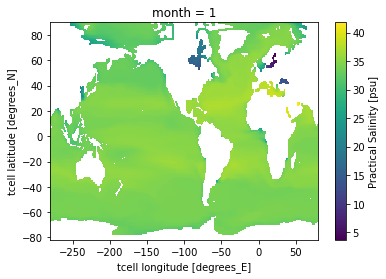

In [33]:
sss_clim[0].plot()

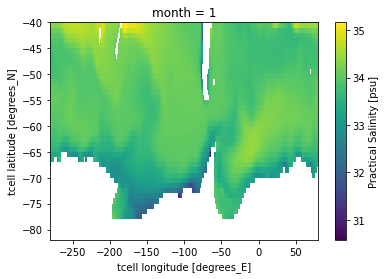

In [34]:
sss_clim_so[0].plot()

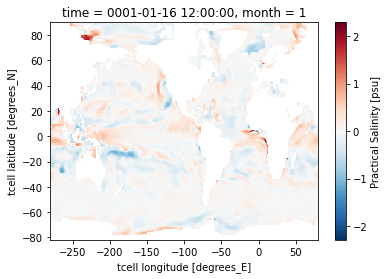

In [104]:
sss_anom[0].plot()

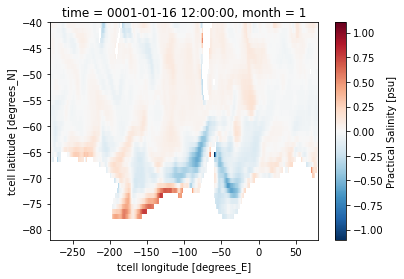

In [105]:
sss_anom_so[0].plot()

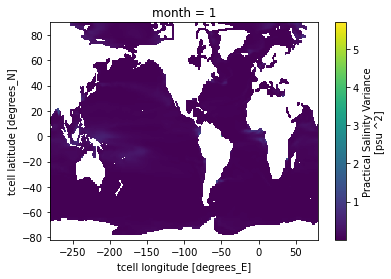

In [211]:
sss_variance[0].plot()

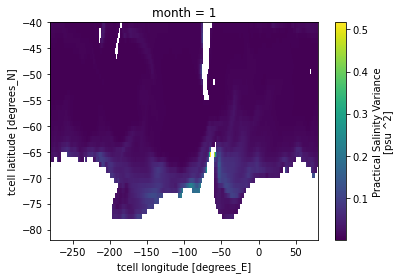

In [36]:
sss_variance_so[0].plot()

In [106]:
sss_anom_so

<xarray.DataArray 'sss_anom' (time: 3600, yt_ocean: 42, xt_ocean: 360)>
dask.array<getitem, shape=(3600, 42, 360), dtype=float32, chunksize=(1, 42, 360), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 0001-01-16 12:00:00 ... 0300-12-16 12:00:00
  * yt_ocean  (yt_ocean) float64 -81.5 -80.5 -79.5 -78.5 ... -42.5 -41.5 -40.5
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
    geolat_t  (yt_ocean, xt_ocean) float32 -81.5 -81.5 -81.5 ... -40.5 -40.5
    geolon_t  (yt_ocean, xt_ocean) float32 -279.5 -278.5 -277.5 ... 78.5 79.5
    month     (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:    Practical Salinity
    units:        psu
    valid_range:  [-10. 100.]
    coordinates:  geolon_t, geolat_t
    description:  sea surface salinity monthly anomaly

#### Sea-ice Concentration (CN)
Already summed over all thickness categories (```CN_INV``` variable).

In [21]:
path_cn = rootdir+subdir_ctrl+'/CN/CN_inv_*.nc'
var_cn = 'CN_INV'

ds_cn = xr.open_mfdataset(path_cn)

## change XT / YT to ocean model grid coordinates xt_ocean / yt_ocean
ds_cn = ds_cn.rename({'XT':'xt_ocean', 'YT':'yt_ocean', 'TIME':'time'})
ds_cn = ds_cn.assign_coords({'xt_ocean':ocean_grid.xt_ocean, 'yt_ocean':ocean_grid.yt_ocean})

## add geolon_t and geolat_t coordinates
ds_cn = ds_cn.assign_coords({'geolon_t':geolon_t, 'geolat_t':geolat_t})

In [22]:
cn_attrs = ds_cn[var_cn].attrs
cn_metrics_attrs = {'long_name': 'CN[K=@SUM]', 'long_name_mod': 'Z=-0.05:1.3', 'valid_range':np.arange(0,2,1,dtype=np.float32),
                    'coordinates':'geolon_t, geolat_t'}

**Global CN**

In [19]:
cn_clim = compute_clim(ds_cn[var_cn])
cn_clim.attrs = cn_metrics_attrs
cn_clim.attrs['description'] = 'sea ice concentration monthly climatology'

cn_anom = compute_anom(ds_cn[var_cn])
cn_anom.attrs = cn_metrics_attrs
cn_anom.attrs['description'] = 'sea ice concentration monthly anomaly'

cn_variance = compute_variance(ds_cn[var_cn])
cn_variance.attrs = {'long_name': 'CN[K=@SUM] Variance', 'long_name_mod': 'Z=-0.05:1.3 Variance', 'coordinates':'geolon_t, geolat_t', 
                    'description':'variance of sea ice concentration monthly anomaly'}

**Southern Ocean CN (resized)**

In [20]:
cn_so = SouthernOcean_resize(ds_cn[var_cn], time=True)

cn_clim_so = compute_clim(cn_so)
cn_clim_so.attrs = cn_metrics_attrs
cn_clim_so.attrs['description'] = 'sea ice concentration monthly climatology'

cn_anom_so = compute_anom(cn_so)
cn_anom_so.attrs = cn_metrics_attrs
cn_anom_so.attrs['description'] = 'sea ice concentration monthly anomaly'

cn_variance_so = compute_variance(cn_so)
cn_variance_so.attrs = {'long_name': 'CN[K=@SUM] Variance', 'long_name_mod': 'Z=-0.05:1.3 Variance', 'coordinates':'geolon_t, geolat_t', 
                    'description':'variance of sea ice concentration monthly anomaly'}

In [21]:
size(cn_anom)

'1.0368 gigabytes'

In [22]:
size(cn_anom_so)

'0.217728 gigabytes'

**Save files**

In [31]:
## already saved

# save_ctrl_clim(var_cn, cn_clim, write_rootdir, subdir_ctrl, regional=False)
# save_ctrl_clim(var_cn, cn_clim_so, write_rootdir, subdir_ctrl, regional=True)

# save_ctrl_anom(var_cn, cn_anom, write_rootdir, subdir_ctrl, regional=False)
# save_ctrl_anom(var_cn, cn_anom_so, write_rootdir, subdir_ctrl, regional=True)

# save_ctrl_variance(var_cn, cn_variance, write_rootdir, subdir_ctrl, regional=False)
# save_ctrl_variance(var_cn, cn_variance_so, write_rootdir, subdir_ctrl, regional=True)

In [25]:
## check that files were saved correctly
sorted(os.listdir(write_rootdir+subdir_ctrl+var_cn+'/'))

['CN_raw',
 'cn_inv_ctrl_global_anomaly.nc',
 'cn_inv_ctrl_global_climatology.nc',
 'cn_inv_ctrl_global_variance.nc',
 'cn_inv_ctrl_so_anomaly.nc',
 'cn_inv_ctrl_so_climatology.nc',
 'cn_inv_ctrl_so_variance.nc',
 'ocean.static.nc']

**Check computations with simple plots**

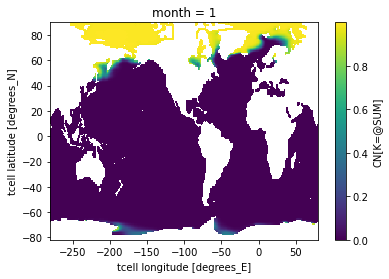

In [25]:
cn_clim[0].plot()

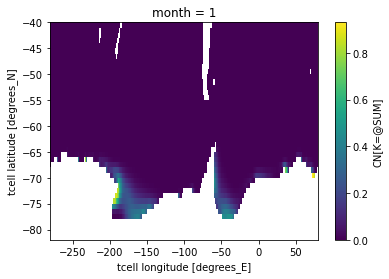

In [26]:
cn_clim_so[0].plot()

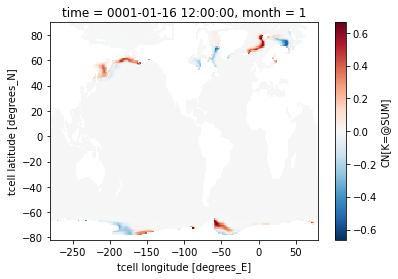

In [27]:
cn_anom[0].plot()

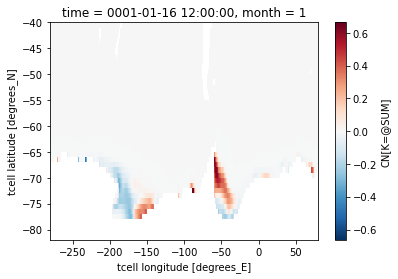

In [28]:
cn_anom_so[0].plot()

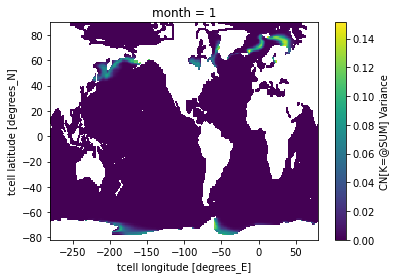

In [29]:
cn_variance[0].plot()

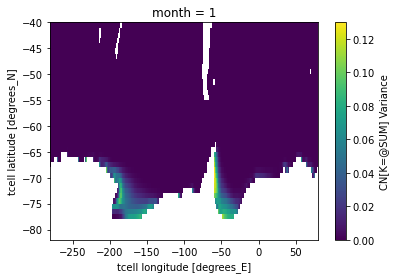

In [30]:
cn_variance_so[0].plot()

#### Net Primary Production (NPP)
*What are the units here?*

In [23]:
path_npp = rootdir+subdir_ctrl+'/NPP/NPP_*.nc'
var_npp = 'NPP'

ds_npp = xr.open_mfdataset(path_npp)

## rename coordinates for continuity
ds_npp = ds_npp.rename({'XT_OCEAN':'xt_ocean', 'YT_OCEAN':'yt_ocean', 'TIME':'time'})

## add geolon_t and geolat_t coordinates
ds_npp = ds_npp.assign_coords({'geolon_t':geolon_t, 'geolat_t':geolat_t})

In [24]:
npp_attrs = ds_npp[var_npp].attrs
npp_metrics_attrs = {'long_name':'Net Primary Production', 'long_name_full': npp_attrs['long_name'], 'coordinates':'geolon_t, geolat_t'}

**Global NPP**

In [35]:
npp_clim = compute_clim(ds_npp[var_npp])
npp_clim.attrs = npp_metrics_attrs
npp_clim.attrs['description'] = 'net primary production monthly climatology'

npp_anom = compute_anom(ds_npp[var_npp])
npp_anom.attrs = npp_metrics_attrs
npp_anom.attrs['description'] = 'net primary production monthly anomaly'

npp_variance = compute_variance(ds_npp[var_npp])
npp_variance.attrs = {'long_name':'Net Primary Production Variance', 'long_name_full': npp_attrs['long_name'],
                      'coordinates':'geolon_t, geolat_t', 'description':'variance of net primary production monthly anomaly'}

**Southern Ocean NPP (resized)**

In [36]:
npp_so = SouthernOcean_resize(ds_npp[var_npp], time=True)

npp_clim_so = compute_clim(npp_so)
npp_clim_so.attrs = npp_metrics_attrs
npp_clim_so.attrs['description'] = 'net primary production monthly climatology'

npp_anom_so = compute_anom(npp_so)
npp_anom_so.attrs = npp_metrics_attrs
npp_anom_so.attrs['description'] = 'net primary production monthly anomaly'

npp_variance_so = compute_variance(npp_so)
npp_variance_so.attrs = {'long_name':'Net Primary Production Variance', 'long_name_full': npp_attrs['long_name'],
                      'coordinates':'geolon_t, geolat_t', 'description':'variance of net primary production monthly anomaly'}

In [39]:
size(npp_anom)

'1.0368 gigabytes'

In [40]:
size(npp_anom_so)

'0.217728 gigabytes'

**Save files**

In [47]:
## already saved

# save_ctrl_clim(var_npp, npp_clim, write_rootdir, subdir_ctrl, regional=False)
# save_ctrl_clim(var_npp, npp_clim_so, write_rootdir, subdir_ctrl, regional=True)

# save_ctrl_anom(var_npp, npp_anom, write_rootdir, subdir_ctrl, regional=False)
# save_ctrl_anom(var_npp, npp_anom_so, write_rootdir, subdir_ctrl, regional=True)

# save_ctrl_variance(var_npp, npp_variance, write_rootdir, subdir_ctrl, regional=False)
# save_ctrl_variance(var_npp, npp_variance_so, write_rootdir, subdir_ctrl, regional=True)

In [28]:
## check that files were saved correctly
sorted(os.listdir(write_rootdir+subdir_ctrl+var_npp.upper()+'/'))

['NPP_raw',
 'npp_ctrl_global_anomaly.nc',
 'npp_ctrl_global_climatology.nc',
 'npp_ctrl_global_variance.nc',
 'npp_ctrl_so_anomaly.nc',
 'npp_ctrl_so_climatology.nc',
 'npp_ctrl_so_variance.nc',
 'ocean.static.nc']

**Check computations with simple plots**

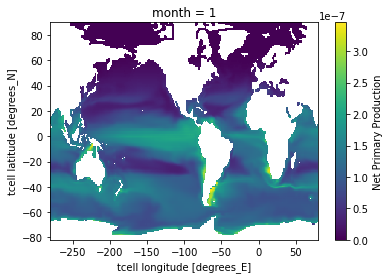

In [41]:
npp_clim[0].plot()

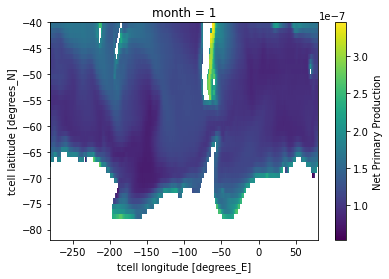

In [42]:
npp_clim_so[0].plot()

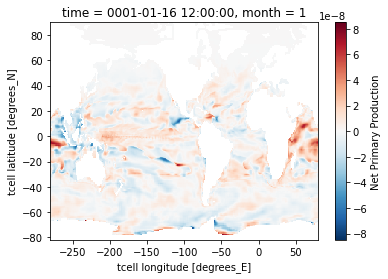

In [43]:
npp_anom[0].plot()

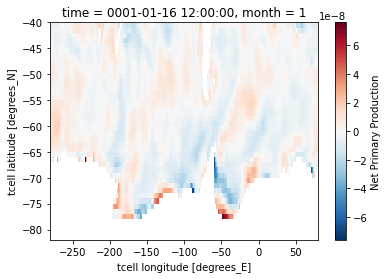

In [44]:
npp_anom_so[0].plot()

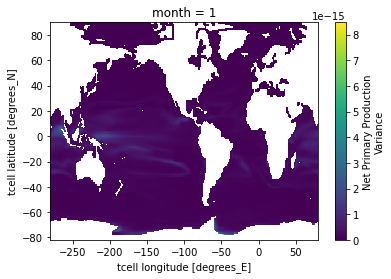

In [45]:
npp_variance[0].plot()

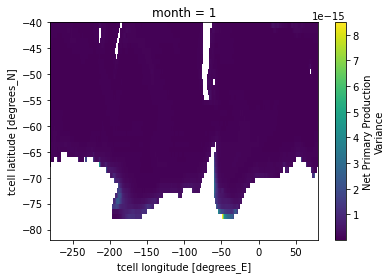

In [46]:
npp_variance_so[0].plot()

#### Surface pCO$_2$ (PCO2SURF)

In [25]:
path_pco2surf = rootdir+subdir_ctrl+'/PCO2SURF/pco2surf_*.nc'
var_pco2surf = 'pco2surf'

ds_pco2surf = xr.open_mfdataset(path_pco2surf)

In [26]:
pco2surf_attrs = ds_pco2surf[var_pco2surf].attrs
pco2surf_metrics_attrs = {'long_name': 'Oceanic pCO2', 'units': 'uatm', 'coordinates':'geolon_t, geolat_t'}

**Global pCO$_2$**

In [51]:
pco2surf_clim = compute_clim(ds_pco2surf[var_pco2surf])
pco2surf_clim.attrs = pco2surf_metrics_attrs
pco2surf_clim.attrs['description'] = 'oceanic surface pCO2 monthly climatology'

pco2surf_anom = compute_anom(ds_pco2surf[var_pco2surf])
pco2surf_anom.attrs = pco2surf_metrics_attrs
pco2surf_anom.attrs['description'] = 'oceanic surface pCO2 monthly anomaly'

pco2surf_variance = compute_variance(ds_pco2surf[var_pco2surf])
pco2surf_variance.attrs = {'long_name': 'Oceanic pCO2 Variance', 'units': 'uatm ^2', 'coordinates':'geolon_t, geolat_t', 
                          'description':'variance of oceanic surface pCO2 monthly anomaly'}

**Southern Ocean pCO$_2$ (resized)**

In [52]:
pco2surf_so = SouthernOcean_resize(ds_pco2surf[var_pco2surf], time=True)

pco2surf_clim_so = compute_clim(pco2surf_so)
pco2surf_clim_so.attrs = pco2surf_metrics_attrs
pco2surf_clim_so.attrs['description'] = 'oceanic surface pCO2 monthly climatology'

pco2surf_anom_so = compute_anom(pco2surf_so)
pco2surf_anom_so.attrs = pco2surf_metrics_attrs
pco2surf_anom_so.attrs['description'] = 'oceanic surface pCO2 monthly anomaly'

pco2surf_variance_so = compute_variance(pco2surf_so)
pco2surf_variance_so.attrs = {'long_name': 'Oceanic pCO2 Variance', 'units': 'uatm ^2', 'coordinates':'geolon_t, geolat_t', 
                          'description':'variance of oceanic surface pCO2 monthly anomaly'}

**Save files**

In [59]:
## already saved

# save_ctrl_clim(var_pco2surf, pco2surf_clim, write_rootdir, subdir_ctrl, regional=False)
# save_ctrl_clim(var_pco2surf, pco2surf_clim_so, write_rootdir, subdir_ctrl, regional=True)

# save_ctrl_anom(var_pco2surf, pco2surf_anom, write_rootdir, subdir_ctrl, regional=False)
# save_ctrl_anom(var_pco2surf, pco2surf_anom_so, write_rootdir, subdir_ctrl, regional=True)

# save_ctrl_variance(var_pco2surf, pco2surf_variance, write_rootdir, subdir_ctrl, regional=False)
# save_ctrl_variance(var_pco2surf, pco2surf_variance_so, write_rootdir, subdir_ctrl, regional=True)

In [31]:
## check that files were saved correctly
sorted(os.listdir(write_rootdir+subdir_ctrl+var_pco2surf.upper()+'/'))

['PCO2SURF_raw',
 'ocean.static.nc',
 'pco2surf_ctrl_global_anomaly.nc',
 'pco2surf_ctrl_global_climatology.nc',
 'pco2surf_ctrl_global_variance.nc',
 'pco2surf_ctrl_so_anomaly.nc',
 'pco2surf_ctrl_so_climatology.nc',
 'pco2surf_ctrl_so_variance.nc']

**Check computations with simple plots**

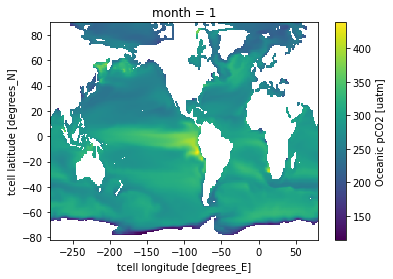

In [53]:
pco2surf_clim[0].plot()

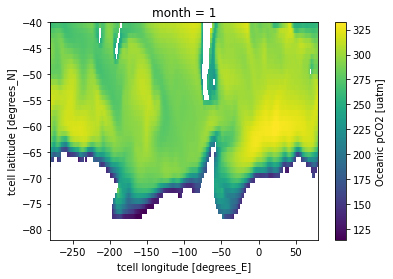

In [54]:
pco2surf_clim_so[0].plot()

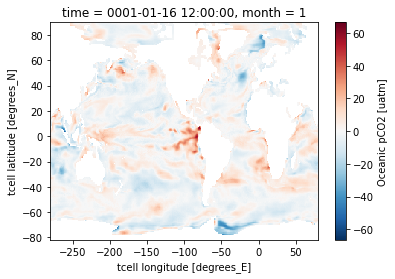

In [55]:
pco2surf_anom[0].plot()

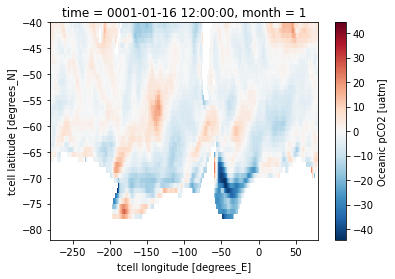

In [56]:
pco2surf_anom_so[0].plot()

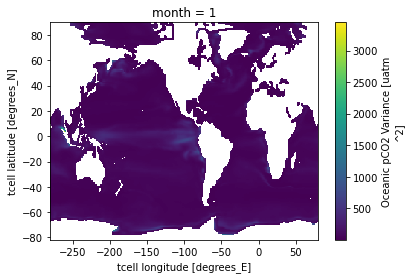

In [57]:
pco2surf_variance[0].plot()

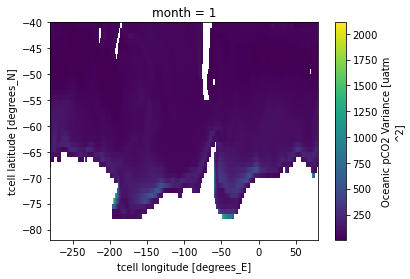

In [58]:
pco2surf_variance_so[0].plot()

# Sea Ice Extent and Volume
Using sea concentration extent (CN_INV) and sea ice thickness (HI) with ocean/ice model grid information.

### Sea Ice Extent

In [44]:
rootdir = '/local/projects/so_predict/esm2m_froelicher/'
subdir_ctrl = 'CTRL/'

path_cn = rootdir+subdir_ctrl+'/CN/CN_inv_*.nc'
ds_cn = xr.open_mfdataset(path_cn)

In [45]:
## create mask for SIE where SIC > 15%
SIE_binary = xr.where(ds_cn.CN_INV > 0.15, 1, 0)

## replace values over land with NaN
SIE_binary = xr.where(np.isnan(ds_cn.CN_INV), np.nan, SIE_binary)

## change type to reduce file size
SIE_binary = SIE_binary.astype(np.float32)

## change coordinates to match ocean model grid (make compatible for areal integral)
SIE_binary = SIE_binary.rename({'XT':'xt_ocean', 'YT':'yt_ocean', 'TIME':'time'})
SIE_binary = SIE_binary.assign_coords({'xt_ocean':ocean_grid.xt_ocean, 'yt_ocean':ocean_grid.yt_ocean})

## add geolon_t and geolat_t coordinates
SIE_binary = SIE_binary.assign_coords({'geolon_t':geolon_t, 'geolat_t':geolat_t})

## add metadata
SIE_binary.name = 'SIE_binary'
SIE_binary.attrs = {'long_name':'Sea Ice Extent (binary threshold @ >15% SIC)',
                    'coordinates':'geolon_t, geolat_t'}

In [46]:
## gridpoint sea ice area
SIE_area = SIE_binary * ocean_grid.area_t
SIE_area.name = 'SIE_area'
SIE_area.attrs = {'long_name':'Sea Ice Extent (spatial)', 'units':'m ^2', 'coordinates':'geolon_t, geolat_t',
                  'description':'area of ice per tracer cell'}

## SIE areal integral for each month of the 300-year control simulation
SIE = SIE_area.where(SouthernOcean_mask == 1).sum(dim={'xt_ocean', 'yt_ocean'})
SIE.name = 'SIE'
SIE.attrs = {'long_name':'Sea Ice Extent', 'units':'m ^2', 'coordinates':'geolon_t, geolat_t',
                  'description':'total sea ice extent south of 40.5 degS'}

## SIE climatology -- single areal integral (total area covered by sea ice in Southern Ocean)
SIE_clim = SIE_area.where(SouthernOcean_mask == 1).sum(dim={'xt_ocean', 'yt_ocean'}).groupby('time.month').mean(dim='time')
SIE_clim.name = 'SIE_clim'
SIE_clim.attrs = {'long_name':'Sea Ice Extent', 'units':'m ^2', 'coordinates':'geolon_t, geolat_t',
                         'description':'monthly climatology of total sea ice extent south of 40.5 degS'}

## SIE anomaly -- single areal integral
SIE_anom = SIE.groupby('time.month') - SIE_clim
SIE_anom.name = 'SIE_anom'
SIE_anom.attrs = {'long_name':'Sea Ice Extent Anomaly', 'units':'m ^2', 'coordinates':'geolon_t, geolat_t',
                         'description':'monthly anomaly of total sea ice extent south of 40.5 degS'}

## SIE variance -- single areal integral
SIE_variance = SIE_anom.groupby('time.month').var(dim='time')
SIE_variance.name = 'SIE_variance'
SIE_variance.attrs = {'long_name':'Variance of Sea Ice Extent Anomaly', 'coordinates':'geolon_t, geolat_t',
                         'description':'variance of monthly anomaly of total sea ice extent south of 40.5 degS'}

In [47]:
## DataArray sizes are small, so I'm saving all of them as one Dataset 
ds_SIE = xr.merge([SIE, SIE_clim, SIE_anom, SIE_variance])
ds_SIE.attrs = {'description':'timeseries of sea ice extent metrics'}

In [48]:
## already saved

# filename = 'sie_ctrl_so_timeseries.nc'
# ds_SIE.to_netcdf(write_rootdir+subdir_ctrl+'SIE'+'/'+filename)

In [49]:
## already saved

# filename = 'sie_ctrl_so_binary.nc'
# SIE_binary.to_netcdf(write_rootdir+subdir_ctrl+'SIE'+'/'+filename)

In [50]:
sorted(os.listdir(write_rootdir+subdir_ctrl+'SIE'))

['CN_raw',
 'ocean.static.nc',
 'sie_ctrl_so_binary.nc',
 'sie_ctrl_so_timeseries.nc']

### Sea Ice Volume
**Use sea ice concentration!**

In [54]:
rootdir = '/local/projects/so_predict/esm2m_froelicher/'
subdir_ctrl = 'CTRL/'

path_hi = rootdir+subdir_ctrl+'/HI/HI_0001_0300.nc'
ds_hi = xr.open_mfdataset(path_hi)

hi = ds_hi.HI.rename({'xt':'xt_ocean', 'yt':'yt_ocean'})
hi = hi.assign_coords({'xt_ocean':ocean_grid.xt_ocean, 'yt_ocean':ocean_grid.yt_ocean})

In [55]:
cn_inv = ds_cn.CN_INV

## change coordinates to match ocean model grid (make compatible for areal integral)
cn_inv = cn_inv.rename({'TIME':'time', 'XT':'xt_ocean', 'YT':'yt_ocean'})
cn_inv = cn_inv.assign_coords({'xt_ocean':ocean_grid.xt_ocean, 'yt_ocean':ocean_grid.yt_ocean})

In [56]:
## gridpoint sea ice area (no thresholding)
SI_total_area = cn_inv * ocean_grid.area_t
SI_total_area.name = 'SI_total_area'
SI_total_area.attrs = {'long_name':'Sea Ice Extent (spatial)', 'units':'m ^2', 'coordinates':'geolon_t, geolat_t',
                  'description':'volume of ice per tracer cell (no thresholding)'}

## gridpoint sea ice volume (SIV)
SIV_area = SI_total_area * hi

## SIV areal integral for each month of the 300-year control simulation
SIV = SIV_area.where(SouthernOcean_mask == 1).sum(dim={'xt_ocean', 'yt_ocean'})
SIV.name = 'SIV'
SIV.attrs = {'long_name':'Sea Ice Volume', 'units':'m ^3', 'coordinates':'geolon_t, geolat_t',
                  'description':'total sea ice volume south of 40.5 degS'}

## SIV climatology -- single areal integral (total volume of ice in Southern Hemisphere)
SIV_clim = SIV.groupby('time.month').mean(dim='time')
SIV_clim.name = 'SIV_clim'
SIV_clim.attrs = {'long_name':'Sea Ice Volume', 'units':'m ^3', 'coordinates':'geolon_t, geolat_t',
                  'description':'monthly climatology of total sea ice volume south of 40.5 degS'}

## SIV anomaly -- single areal integral
SIV_anom = SIV.groupby('time.month') - SIV_clim
SIV_anom.name = 'SIV_anom'
SIV_anom.attrs = {'long_name':'Sea Ice Volume Anomaly', 'units':'m ^3', 'coordinates':'geolon_t, geolat_t',
                  'description':'monthly anomaly of total sea ice volume south of 40.5 degS'}

## SIV variance -- single areal integral
SIV_variance = SIV_anom.groupby('time.month').var(dim='time')
SIV_variance.name = 'SIV_variance'
SIV_variance.attrs = {'long_name':'Sea Ice Volume Variance', 'coordinates':'geolon_t, geolat_t',
                      'description':'variance of monthly anomaly of total sea ice volume south of 40.5 degS'}

In [57]:
## DataArray sizes are small, so I'm saving all of them as one Dataset 
ds_SIV = xr.merge([SIV, SIV_clim, SIV_anom, SIV_variance])
ds_SIV.attrs = {'description':'timeseries of sea ice volume metrics'}

In [58]:
## already saved

# filename = 'siv_ctrl_so_timeseries.nc'
# ds_SIV.to_netcdf(write_rootdir+subdir_ctrl+'SIV'+'/'+filename)

In [311]:
sorted(os.listdir(write_rootdir+subdir_ctrl+'SIV'))

['CN_raw', 'HI_raw', 'ocean.static.nc', 'siv_ctrl_so_timeseries.nc']

**Quick Check:** Sea ice thickness is mostly less than 1 meter in the Southern Hemisphere, so it makes sense that SIV values are less than SIC values. (see below for plot of grid cells with sea ice thickness greater than 1 meter)

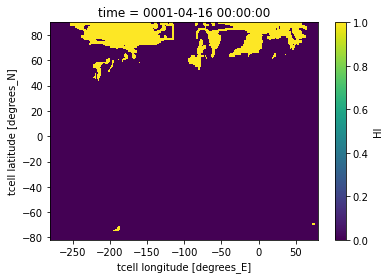

In [60]:
threshold = 0.5
month = 3      # September should be around peak sea ice in Southern Ocean
hi_clim = hi.groupby('time.month').mean(dim='time')

t = xr.where(hi[month] > threshold, 1, 0)
# t = xr.where(np.isnan(HI_clim[month]), np.nan, t)
t.plot()

### Sea Ice Edge Position
**Still working on this.** I can locate the edge using ```SIE_binary```, but I have trouble keeping the coordinates for the edge cells.

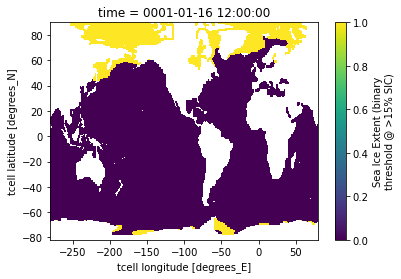

In [61]:
SIE_binary[0].plot()

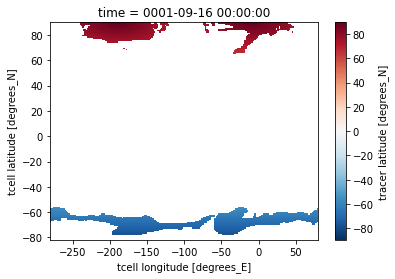

In [279]:
SIE_binary.geolat_t.where(SIE_binary == 1)[:,:,8].plot()

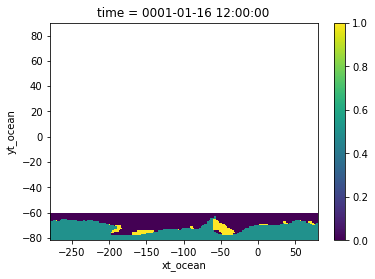

In [272]:
r = xr.where(np.isnan(SIE_binary[0]), 0.5, SIE_binary[0])
r = xr.where(ocean_grid.geolat_t < -60, r, np.nan)
lat = r.groupby('xt_ocean').max(dim='yt_ocean').chunk((360))
r.plot()